In [102]:
import numpy as np
import sympy as sp
from numpy.linalg import inv, norm
import matplotlib.pyplot as plt
from sympy.tensor.array import derive_by_array
from sympy.matrices.dense import matrix_multiply_elementwise as times

In [103]:
n = 3
m = 5

x = sp.symbols("".join([f"x_{i+1} " for i in range(n) ])[:-1])
x_vec = sp.Matrix(x)
m_ones = sp.Matrix([1]*m)
n_ones = sp.Matrix([1]*n)
a = [sp.symbols("".join([rf"a_{i+1}{j+1} " for j in range(n) ])[:-1]) for i in range(m)]
A = sp.Matrix(a).T
C = sp.Matrix(sp.symbols("".join([f"c_{i+1} " for i in range(n) ])[:-1]))

f1 = (C.T*x_vec)[0]
Df1 = C
Hf1 = sp.Integer(0)*sp.eye(n)

f2 = sum((m_ones-A.T*x_vec).applyfunc(sp.ln))
Df2 = -A*(m_ones-A.T*x_vec).applyfunc(lambda x: 1/x)
Hf2 = -A*sp.diag(*(m_ones-A.T*x_vec).applyfunc(lambda x: 1/x**2))*A.T

f3 = sum((n_ones-x_vec.applyfunc(lambda x: x**2)).applyfunc(sp.ln))
Df3 = times((n_ones-x_vec.applyfunc(lambda x: x**2)).applyfunc(lambda x: 1/x), -2*x_vec)
Hf3 = sp.diag(*times(-2*(n_ones+x_vec.applyfunc(lambda x: x**2)), (n_ones-x_vec.applyfunc(lambda x: x**2)).applyfunc(lambda x: 1/(x)**2)))

# Hf(x_0) - (Hf1+Hf2+Hf3).subs({x[i]:x_0[i] for i in range(n)}).subs({A[i,j]:a[i,j] for i in range(n) for j in range(m)}).subs({C[i]:c[i] for i in range(n)})

In [104]:
n = 500
m = 200
c = np.random.normal(0,1,n)
a = np.random.normal(0,1,(n,m))
a = a/norm(a.T, axis = 1) # Uniformly distributed over S^{m-1}
x_0 = np.repeat(0,n)

f = lambda x: c.T@x - sum(np.log(1-a.T@x) - sum(np.log(1-x**2)))
Df = lambda x: c - a@(1/(1-a.T@x))  - (2*x)/(1-x**2)
Hf = lambda x: 0 - a*(1/(1-a.T@x)**2)@a.T - np.diag(2*(x**2 + 1)/(1-x**2)**2)

In [105]:
from scipy.optimize import minimize
from scipy.optimize import NonlinearConstraint, LinearConstraint

def is_in_domain(x):
    return not ((a.T@x > 1).any() or (x**2 > 1).any())

# constraint_function1 = lambda x : 1-a.T@x
# constraint_function2 = lambda x : 1-x**2

# con1 = LinearConstraint(a.T, -np.inf, 0)
# con2 = NonlinearConstraint(constraint_function2, 0.0001, np.inf)

# res = minimize(f, x_0,method='trust-constr',
#                jac=Df, hess=Hf,
#                options={'xtol': 1e-8, 'disp': True}, constraints=[con1,con2])

In [106]:
x_test = x_0 + np.random.normal(0,1/(n**2),n)
f_taylor = lambda x: f(x_0) + Df(x_0)@(x_0-x) + (1/2)*(x_0-x).T@Hf(x_0)@(x_0-x)
f_taylor(x_test) - f(x_test), norm(x_test - x_0)

(7.28064337443776e-05, 8.920081058192356e-05)

In [107]:
iterations = 200
epsilon = 1/10**6
alpha = 1
rho = 0.94
gamma = 0.6
x_0 = np.repeat(0,n)

In [108]:
def backtracking(alpha, gamma, rho, x_k, f_k, Df_k, p_k):
    alpha_k = alpha
    backtracking = f(x_k + alpha_k*p_k) - (f_k + gamma*alpha_k*Df_k.T@p_k)
    while backtracking > 0 :
        alpha_k = alpha_k * rho
        backtracking = f(x_k + alpha_k*p_k) - (f_k + gamma*alpha_k*Df_k.T@p_k)
    return alpha_k

def newton(alpha, gamma, rho, iterations, x_0, f, Df, Hf):
    x_k = x_0
    x_list = [x_k]
    for i in range(iterations):
        f_k = f(x_k)
        print(x_k.shape)
        Df_k = Df(x_k)
        print(f_k, norm(Df_k))
        B_k = Hf(x_k)
        p_k = -inv(B_k)@Df_k
        alpha_k = 1 # backtracking(alpha, gamma, rho, x_k, f_k, Df_k, p_k)

        x_k_temp = x_k+alpha_k*p_k
        i = 0
        while not is_in_domain(x_k_temp) or i > 20:
            alpha_k *= rho
            x_k_temp = x_k+alpha_k*p_k
            i += 1
        x_k = x_k_temp
        if not is_in_domain(x_k):
            break
        x_list.append(x_k)
        
        if norm(Df_k) < epsilon:
            break
    return x_list

x_list1 = newton(alpha, gamma, rho, iterations, x_0, f, Df, Hf)
# x_list2 = gradient_descent(alpha, gamma, rho, iterations, x_0, f, Df, Hf)

(500,)
0.0 26.437020417535372
(500,)
-10209.499731083646 45.82560326141332
(500,)
-17144.338914418455 21.58452126185725
(500,)
-15900.775579191479 9.814860877338072
(500,)
-15743.751699456334 4.0558570391747955
(500,)
-15667.3711176726 1.3369778694677557
(500,)
-15628.09542012286 0.25662626068279576
(500,)
-15618.20786653979 0.013521238943922353
(500,)
-15617.646807123907 4.1527466087016974e-05
(500,)
-15617.645076530347 3.940372634946317e-10


In [109]:
def gradient_descent(alpha, gamma, rho, iterations, x_0, f, Df, Hf):
    x_k = x_0
    x_list = [x_k]
    B_k = np.eye(len(x_k))
    for i in range(iterations):
        f_k = f(x_k)
        Df_k = Df(x_k)
        p_k = -Df_k

        print(f_k, norm(Df_k))
        alpha_k = alpha
        x_k_temp = x_k+alpha_k*p_k

        i = 0
        while not is_in_domain(x_k_temp) and i < 100:
            alpha_k *= rho
            x_k_temp = x_k+alpha_k*p_k
            i += 1
        print(is_in_domain(x_k_temp))
        
        if not is_in_domain(x_k_temp):
            break
        alpha_k = backtracking(alpha_k, gamma, rho, x_k, f_k, Df_k, p_k)
        x_k = x_k+alpha_k*p_k
        x_list.append(x_k)
    return x_list

x_list2 = gradient_descent(alpha, gamma, rho, iterations, x_0, f, Df, Hf)

0.0 26.437020417535372
True
-6256.509937922265 60.81941791704071
False


In [110]:
np.array([[0,1]]).reshape(2,)

array([0, 1])

(500,)
-6256.509937922265 60.81941791704071
(500,)
-8739.704496879254 30.693555415062445
(500,)
-16431.738708076515 321.4305783492417
(500,)
-16584.988300103294 159.83728341005164
(500,)
-16284.014017577403 79.02472741175846
(500,)
-16128.338069392015 38.70918701710702
(500,)
-15963.616062306637 18.566059624326307
(500,)
-15844.289060070829 8.518754900948977
(500,)
-15742.100763948622 3.5497515782976596
(500,)
-15667.408504700159 1.186608351553309
(500,)
-15628.299197795948 0.2337317342096051
(500,)
-15618.248440337713 0.012977701052448925
(500,)
-15617.647142455511 4.4387844490040106e-05
(500,)
-15617.645076538278 5.226149078239034e-10


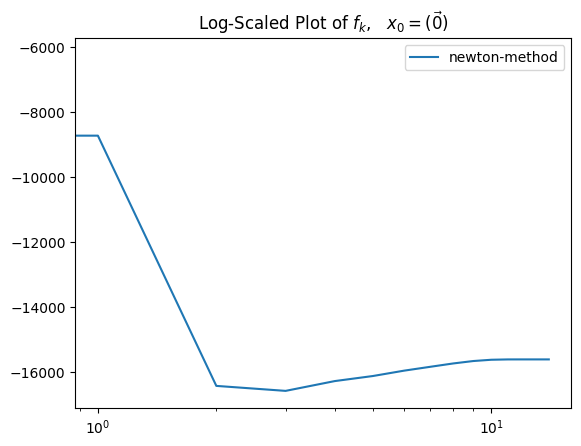

In [111]:
x_list1 = newton(alpha, gamma, rho, iterations, x_list2[-1], f, Df, Hf)
f_list1 = np.apply_along_axis(f, axis = 0, arr=np.array(x_list1).T)
plt.plot(f_list1, label='newton-method' )
plt.xscale('log')
plt.title(f'Log-Scaled Plot of $f_k$,   $x_0 = (\\vec{{0}})$')
plt.legend()

Text(0.5, 1.0, '$f_k$')

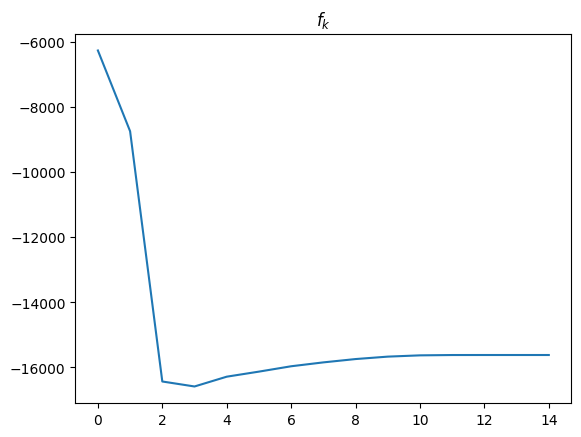

In [112]:
plt.plot(np.apply_along_axis(f, axis = 1, arr=x_list1))
plt.title("$f_k$")